# 0. Set Up

In [3]:
# Import general modules/packages here. 
# It is a good practice to run all cells in the Notebook sequentially to avoid unexpected outputs.

import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

!pip install pytorch-lightning==0.7.6 > /dev/null
import pytorch_lightning as pl


# force Jupyter to update loaded modules as they change 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Before you continue ...
Please download and add the folder from the exercise page to the root directory of this project.      
www.rostlab.org/~bindpredict/datasets_pp1cb/disorder.zip


The folder name should be **data**. The folder contains following files: 


-- baseline_embeddings_disorder.h5     
-- disorder_seq.fasta    
-- README.md      
-- disorder_labels.fasta     
-- MSAs      
 
 
**TO DO**: add a method for automatical download.


Run the next cell to display the structure of the repo: 

In [4]:
!ls

data  lightning_logs  methods  README.md  venv	visualization  workflow.ipynb


**methods** 


-- utils    
-- nn
 Contains the actual code for pre-processing and definition of our NN. 


**visualization**     
Contains methods for ploting and the output folder with images. 



This notebook is meant to be a main driver which imports all methods and performs machine learning pipeline in abstract high-level calls. It means: we will implement the actual dataset import, network definition and training here by importing an appropriate function into the notebook. 

# Table of contents 
TO DO 

# 1. Dataset preparation

## Visualize the dataset

Reading Z-scores...done! Found 1102 proteins.
Plotting histogram of all z-scores...done! 125223 usable z-scores in total. 5.05% of all z-scores were unknown and hence removed from the histogram.
Plotting histogram of the protein lengths...done! Median length: 114.0.


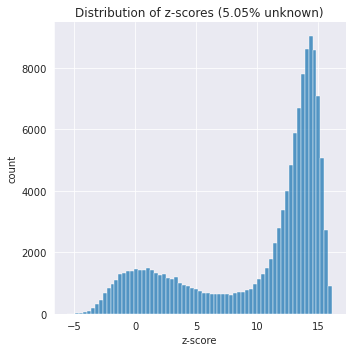

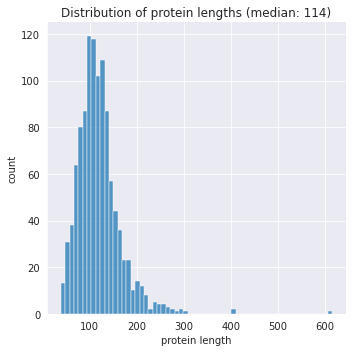

In [5]:
import visualization.visualize_dataset as vis
from methods.utils.read_embeddings import read_z_scores

z_scores = read_z_scores(z_score_file="./data/disorder_labels.fasta")
vis.plot_z_score_histogram(z_scores)
vis.plot_protein_length_histogram(z_scores)

## Embeddings
Here is an example how an embedding works. 
Each aa seq is represented as a numpy array of size (num_of_aa, 1024), where each number is a z-score. 

In [6]:
import methods.nn.disorder_dataset as dd

dataset = dd.load_dataset()

Reading embeddings...done! Found 1102 proteins.
Reading Z-scores...done! Found 1102 proteins.
Matching protein IDs...done!
Samples per bin [ 94  66 256 686]
Thresholds of bins [-1.89092126  2.24897056  6.38886238 10.5287542  14.66864602]


In [7]:
print(len(dataset[0][0]))
print(len(dataset[1][0]))
print(len(dataset[2][0]))

190
54
118


In [8]:
test_index = np.random.randint(10)
test_x = dataset.x[test_index]
test_y = dataset.y[test_index]
seq_length, embedding_dim = test_x.shape
print(test_x.shape)
print(test_y.shape)
print(test_y)
#test_y.sum()/len(test_y)

(133, 1024)
()
8.721429752066117


## Load the dataset

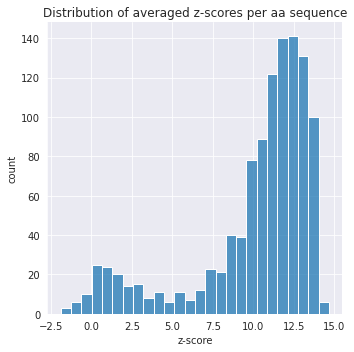

In [9]:
from visualization.visualize_dataset import plot_avg_z_score_histogramm

plot_avg_z_score_histogramm(dataset.avg_y)

## Split the dataset to k-folds

### Sample train/test/val datasets k-times
Sampling from each of the bins ensures stratification or, in other words, that the distribution of the data is equal in every set. 


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from methods.nn.disorder_dataset import collate
from methods.nn.disorder_dataset import DisorderDataset


def nested_cross_validation(dataset,
                            model=None,
                            mode='print_fold_info',
                            k=10, *kwargs):
    
    # Set fixed random number seed
    SEED = 1
    torch.manual_seed(SEED) 
    
    # Define the K-fold Cross Validator
    skf = StratifiedKFold(n_splits=k, random_state=SEED, shuffle=True)

    # For folds results
    results = {}
    # For debugging loaders 
    loaders = {}

    # Nested K-Fold Cross Validation model evaluation
    # We split the data stratified on artificially constructed bins in df['bins'
    # and extract indices.
    
    # By splitting we only extract indices of samples for each test/train/val sets,
    # thus we only need either X or y (equal length).
    # For stratification, however, we require the artificially assigned bins whic are also defined in the 
    # dataset class
    
    data = dataset.y
    stratify_on = dataset.bins
    
    for fold, (train_val_ids, test_ids) in enumerate(skf.split(data,stratify_on)):
        
        print(f"Fold {fold}")
        
        train_ids, val_ids = train_test_split(train_val_ids, 
                                  test_size=0.20,  # 0.25 x 0.8 = 0.2
                                  stratify=stratify_on[train_val_ids], 
                                  random_state=SEED)
    
        # for a fully connected CNN, all proteins within a batch have to have the same size
        # for now we can circumvent that by using a batch size of one, but we might be able
        # to make this more efficient later
        # see https://discuss.pytorch.org/t/using-variable-sized-input-is-padding-required/18131/6
        # for more details
        batch_size = 2

        # Define data loaders for training and testing data in this fold
        valloader = torch.utils.data.DataLoader(
                          dataset, 
                          batch_size=batch_size,
                          collate_fn=collate,
                          sampler=val_ids)

        trainloader = torch.utils.data.DataLoader(
                          dataset,
                          collate_fn=collate,
                          batch_size=batch_size, sampler=train_ids)

        testloader = torch.utils.data.DataLoader(
                          dataset,
                          collate_fn=collate,
                          batch_size=batch_size, sampler=test_ids)
        
        if mode == 'print_fold_info':
            
            loaders[fold] = [trainloader, valloader, testloader]
            
            print('train -  {}, avg_len - {:.2f}  |  val -  {}, avg_len - {:.2f}'.format(
                np.sum(np.bincount(stratify_on[train_ids])),
                np.sum(dataset.aa_len[train_ids])/len(train_ids),
                np.sum(np.bincount(stratify_on[val_ids])),
                np.sum(dataset.aa_len[val_ids])/len(val_ids)))

            print('test -  {}, avg_len - {:.2f}'.format(
                np.sum(np.bincount(stratify_on[test_ids])),
                np.sum(dataset.aa_len[test_ids])/len(test_ids)))
            
            show_batches = 1

            for i, batch in enumerate(trainloader):
                if i == show_batches:
                    break

                # the batch consists of the embeddings and the labels
                embeddings = batch[0]
                z_scores = batch[1]
                print(f'Embedding: \nSize: {len(embeddings)}, Individual: {[len(x) for x in embeddings]}')
                print(f'Z-Scores: \nIndividual: {z_scores}')
                #print('\nSequence Lengths: \n', batch['lengths'].size())
                # print('Batch shape, ',batch['z_scores'].shape)
                print('\n')

            print()
            
        elif mode == 'evaluate':

            trainer = pl.Trainer(
                weights_summary=None,
                max_epochs=100,
                progress_bar_refresh_rate=1, # to prevent notebook crashes
                #Uncomment to use GPU if available
                #gpus=1,
                deterministic=True
            )
            trainer.fit(model, train_dataloader=trainloader,val_dataloaders=valloader)
            
        else:
            print("Mode is not specified!")
            break
        
    if mode == 'evaluate':
        return results
    else:
        return loaders

In [11]:
nested_cross_validation(dataset)

Fold 0
train -  792, avg_len - 120.46  |  val -  199, avg_len - 115.51
test -  111, avg_len - 121.62
Embedding: 
Size: 2, Individual: [112, 75]
Z-Scores: 
Individual: [tensor(9.9336), tensor(7.8119)]



Fold 1
train -  792, avg_len - 119.06  |  val -  199, avg_len - 122.26
test -  111, avg_len - 119.47
Embedding: 
Size: 2, Individual: [55, 199]
Z-Scores: 
Individual: [tensor(8.6969), tensor(9.8363)]



Fold 2
train -  793, avg_len - 120.28  |  val -  199, avg_len - 117.67
test -  110, avg_len - 118.97
Embedding: 
Size: 2, Individual: [177, 199]
Z-Scores: 
Individual: [tensor(7.4860), tensor(9.8363)]



Fold 3
train -  793, avg_len - 118.82  |  val -  199, avg_len - 119.79
test -  110, avg_len - 125.65
Embedding: 
Size: 2, Individual: [105, 199]
Z-Scores: 
Individual: [tensor(9.6680), tensor(9.8363)]



Fold 4
train -  793, avg_len - 119.47  |  val -  199, avg_len - 120.90
test -  110, avg_len - 118.98
Embedding: 
Size: 2, Individual: [162, 125]
Z-Scores: 
Individual: [tensor(9.6139), t

{0: [<torch.utils.data.dataloader.DataLoader at 0x7fecc0ab4e80>,
 1: [<torch.utils.data.dataloader.DataLoader at 0x7fecc0b089a0>,
 2: [<torch.utils.data.dataloader.DataLoader at 0x7fecc0a2cc40>,
 3: [<torch.utils.data.dataloader.DataLoader at 0x7fecc0a2cca0>,
 4: [<torch.utils.data.dataloader.DataLoader at 0x7fecc0a81cd0>,
 5: [<torch.utils.data.dataloader.DataLoader at 0x7fecc0a2ceb0>,
 6: [<torch.utils.data.dataloader.DataLoader at 0x7fecc0a2fe20>,
 7: [<torch.utils.data.dataloader.DataLoader at 0x7fecc0a2fcd0>,
 8: [<torch.utils.data.dataloader.DataLoader at 0x7fecc0a2fa30>,
 9: [<torch.utils.data.dataloader.DataLoader at 0x7fecc0a2fca0>,
  <torch.utils.data.dataloader.DataLoader at 0x7fecc0a2f850>]}

# 2. Create a model

Trying out a fully connected CNN.

In [ ]:
from methods.nn.model import ConvNet

hparams = {'hidden_size': 112,
           "learning_rate": 1e-4
           }
model = ConvNet(hparams)

nested_cross_validation(dataset, model, mode='evaluate')

In [ ]:
from methods.nn.model import FeedForwardNet
from pytorch_lightning import Trainer, seed_everything

seed_everything = 1


########################################################################
# TODO: Define your hyper parameters here!                             #
########################################################################
hparams = {'hidden_size': 112,
           "learning_rate": 1e-4
           }

########################################################################
#                           END OF YOUR CODE                           #
########################################################################
model = FeedForwardNet(hparams)

# 3. Train a model

In [ ]:
nested_cross_validation(dataset, model, mode='evaluate')

## Set up Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

# 4. Visualize results